```{math}
\newcommand{\R}{\mathbb{R}}
\newcommand{\>}{\rightarrow}
\newcommand{\enc}{\varepsilon}
\newcommand{\dec}{\mathcal{D}}
\newcommand{\norm}[1]{\vert\vert #1 \vert\vert}
\newcommand{\E}{\mathop{{}\mathbb{E}}}
```


Learning Distributed Codecs for Classification
=======================
Consider the distributed setting where a central node receives data from $d$ remote nodes which do not communicate with each other. The central node is equiped with a binary classifier $C: \R^d \> \{0, 1\}$. Each remote node $i$ collects a point $x_i \in \R$ and sends it to the central node where they are concatenated and fed into the classifier as $x = (x_1, x_2, \dots, x_d) \in \R^d$.

If $x_i$ is represented by a $32$ bit floating-point number then $32 d$ bits are required to transmit $x$. Our goal is to reduce this number by using quantization. At each remote node we place an encoder $\enc_i: \R \> \{0, 1, 2, \dots, 2^{R_i}-1\} = [2^{R_i}-1]$ responsible for mapping $x_i$ to an integer between $0$ and $2^{R_i}-1$, where $R_i$ is the number of bits we attribute to node $i$. At the transmitter, a decoder $\dec:[2^{R_1}-1] \times [2^{R_2}-1] \dots \times [2^{R_d}-1] \> \R^d$ maps the tuple of integers $q = (q_1, q_2, \dots, q_d) = (\enc_1(x_1), \enc_2(x_2), \dots, \enc_d(x_d))$ to a reconstruction point in $\R^d$.

As an example, consider the following code, where we've taken $R_i = R, \forall i \in [d]$

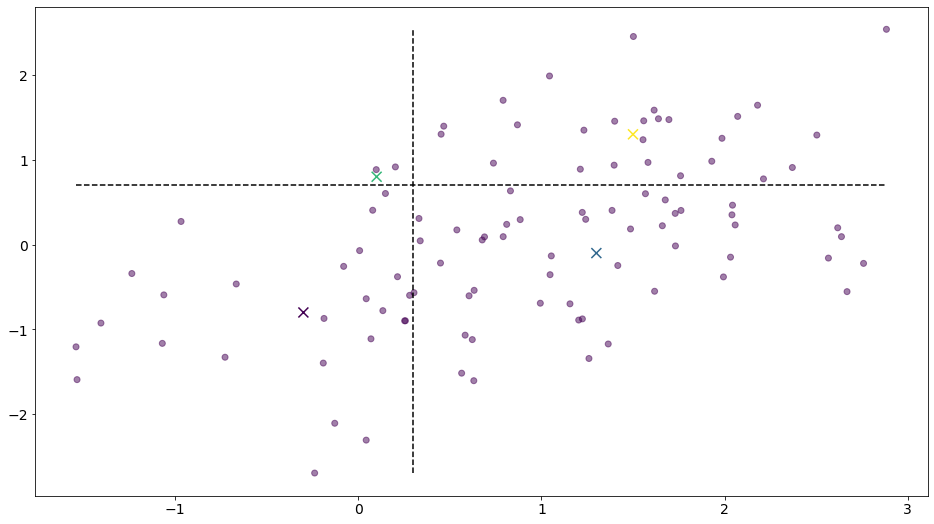

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
np.random.seed(0)

R = 1
d = 2
N = 100
M = 2**(d*R)
b = 2**R - 1

# initialize these for performance
flattener = {
    R: {d: xr.DataArray([2**(R*i) for i in range(d)], dims='d')
        for d in range(10)}
    for R in range(10)
}

def generate_2d_dataset(N, ρ=0.0):
    μ = [1, 0]
    Σ = [[1, ρ],
         [ρ, 1]]
    X = np.random.multivariate_normal(μ, Σ, size=N)
    X = xr.DataArray(X, dims=['N', 'd'])
    return X


def encode(X, BX, BQ):
    # Q = (X > BX).sum('b')
    Q = np.power(X - BX, 2).argmin('b')
    return BQ[Q]


def decode(Q, RX, R):
    d = Q['d'].size
    Q_flat = Q @ flattener[R][d]
    return RX[Q_flat], Q_flat


X = generate_2d_dataset(N, 0.5)
BX = xr.DataArray([[0.3, 0.7]],
                  dims=['b', 'd'])
BQ = xr.DataArray([[0, 0],
                   [1, 1]],
                  dims=['b', 'd'])
RX = xr.DataArray([[-0.3, -0.8],
                   [ 1.3, -0.1],
                   [ 0.1,  0.8],
                   [ 1.5,  1.3]],
                  dims=['M', 'd'])

Q = encode(X, BX, BQ)
Y, Q_flat = decode(Q, RX, R)
plt.scatter(*X.T, c=Q_flat, alpha=0.5)
plt.scatter(*RX.T, marker='x', c=RX['M'], s=100)
plt.vlines(BX.sel(d=0), X.sel(d=1).min(), X.sel(d=1).max(), linestyle='dashed')
plt.hlines(BX.sel(d=1), X.sel(d=0).min(), X.sel(d=0).max(), linestyle='dashed')
plt.show()

The reconstruction points available at the decoder are stored in `RX` of shape $(M = 2^{dR}, d)$. Quantization regions are defined by an array of boundaries `BX` and the assigned quantization integers `BQ`.

Our loss considers the euclidean distortion caused by quantization, $\ell(x, q, \dec) = \norm{x - \dec(q)}^2$, which can be seen as the distortion caused by choosing $(q, \dec)$ to quantize $x$. The total loss over the dataset $S$ is 

```{math}
\begin{equation}
\begin{split}
    L_S(\enc, \dec) &= \E_{x \sim S} \ell(x, \enc(x), \dec) \\
                    &= \frac{1}{N} \sum_{x \in S} \norm{x - \dec(\enc(x))}^2 \\
                    &= \frac{1}{N} \sum_{q} \sum_{\substack{x \in S \\ \enc(x) = q}} \norm{x - \dec(q)}^2
\end{split}
\end{equation}
```

In [2]:
def calc_loss(X, Q_flat, RX):
    return np.power(X - RX.sel(M=Q_flat), 2).sum('d')

print(calc_loss(X, Q, RX).mean())

<xarray.DataArray ()>
array(4.35482568)


## Optimal decoder

From the last line of the equation above, we can see that the decoder minimizing $L_S(\enc, \dec)$ is

```{math}
\dec^\star(q) = \E[ x \vert \enc(x) = q]
```

In [3]:
def sample_from_X(X, size):
    N = X['N'].size
    i_sample = np.random.randint(N, size=size)
    return X[i_sample]


def complete_RX(X, RX, M):
    ΔM = M - RX['M'].size
    ΔRX = (sample_from_X(X, ΔM)
           .rename(N='M')
           .drop_vars('M', errors='ignore'))
    RX = RX.drop_vars('M', errors='ignore')
    return xr.concat((RX, ΔRX), dim='M')

def optimize_decoder(X, Q, RX, R):
    d = X['d'].size
    M = 2**(d*R)

    if Q.attrs.get('flat', False):
        Q_flat = Q
    else:
        Q_flat = Q @ flattener[R][d]

    RX = (X.groupby(Q_flat)
           .mean()
           .rename(group='M'))
    return complete_RX(X, RX, M)

RX_opt = optimize_decoder(X, Q, RX, R)
print(RX_opt)

<xarray.DataArray (M: 4, d: 2)>
array([[ 0.92944004,  0.07221871],
       [ 0.3040976 , -0.56691949],
       [ 0.25716078, -0.89784931],
       [ 0.68909622,  0.09108559]])
Dimensions without coordinates: M, d


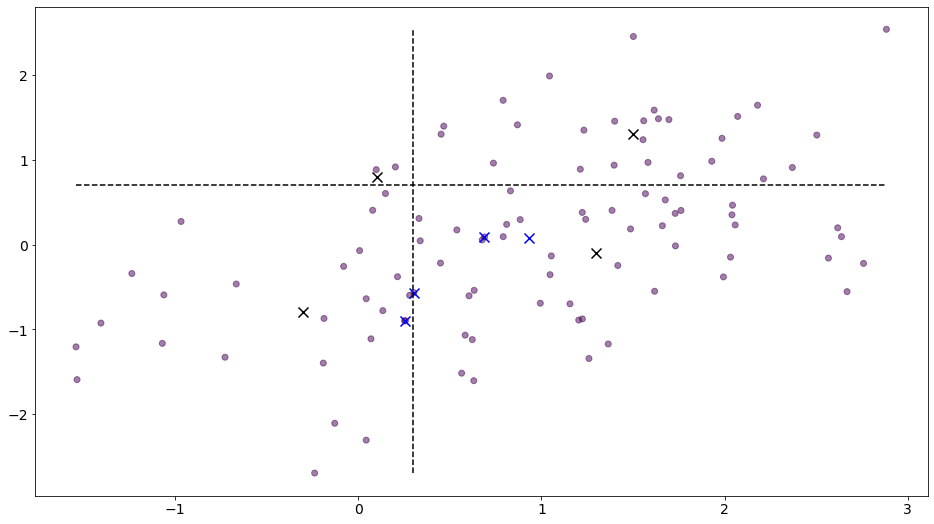

In [4]:
plt.scatter(*X.T, c=Q_flat, alpha=0.5)
plt.scatter(*RX.T, marker='x', c='k', s=100)
plt.scatter(*RX_opt.T, marker='x', c='blue', s=100)
plt.vlines(BX.sel(d=0), X.sel(d=1).min(), X.sel(d=1).max(), linestyle='dashed')
plt.hlines(BX.sel(d=1), X.sel(d=0).min(), X.sel(d=0).max(), linestyle='dashed')
plt.show()

## Optimal encoder
The encoders are optimized greedly at each dimension.

```{math}
\enc_i(x_i) = \arg\min_{q_i} \ell(x, q, \dec^\star)
```

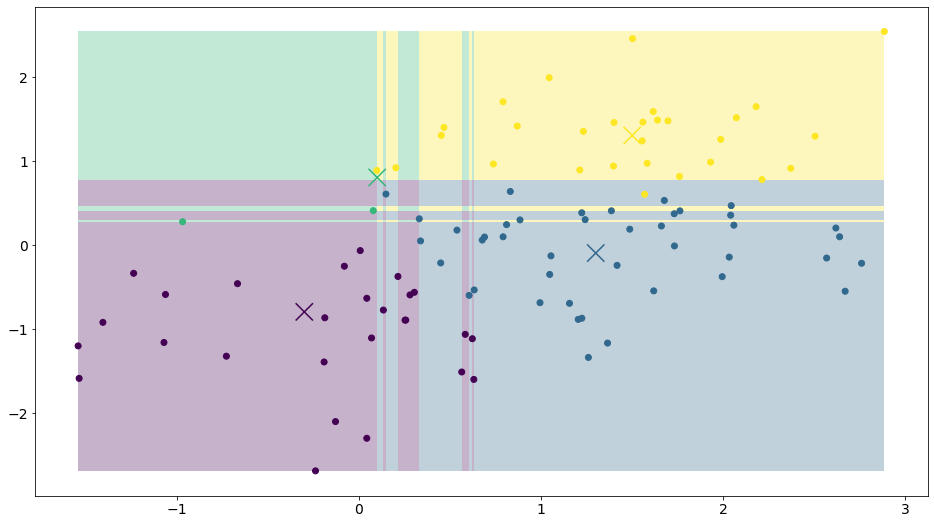

In [5]:
def freeze_Q(Q, i, R):
    N = Q['N'].size
    Q_exp = Q.expand_dims(q=2**R).copy()
    K = xr.DataArray(np.tile(np.arange(2**R), (N,1)), dims=['N', 'q'])
    Q_exp.loc[dict(d=i)] = K.T
    return Q_exp


def optimize_encoder(X, Q, RX, R):
    d = X['d'].size
    for i in range(d):
        Qi = freeze_Q(Q, i, R)
        qi_new = calc_loss(X, Qi @ flattener[R][d], RX).argmin('q')
        Q.loc[dict(d=i)] = qi_new
    BX = X.rename(N='b')
    BQ = Q.rename(N='b')
    isort = BX.argsort(axis=0)
    return BX[isort], BQ[isort]


def plot(X, BX, BQ, R):
    d = X['d'].size
    Q_grid = xr.DataArray(np.meshgrid(*BQ.T), dims=['d', 'b', 'bb'])
    Q = encode(X, BX, BQ)
    plt.pcolor(*BX.T, Q_grid @ flattener[R][d], alpha=0.3, snap=True)
    plt.scatter(*X.T, c=Q @ flattener[R][d])
    plt.scatter(*RX.T, marker='x', c=RX['M'], s=300)


BX, BQ = optimize_encoder(X, Q, RX, R)
Q_opt = encode(X, BX, BQ)

plot(X, BX, BQ, R)
plt.show()

## Distributed Lloyd-max

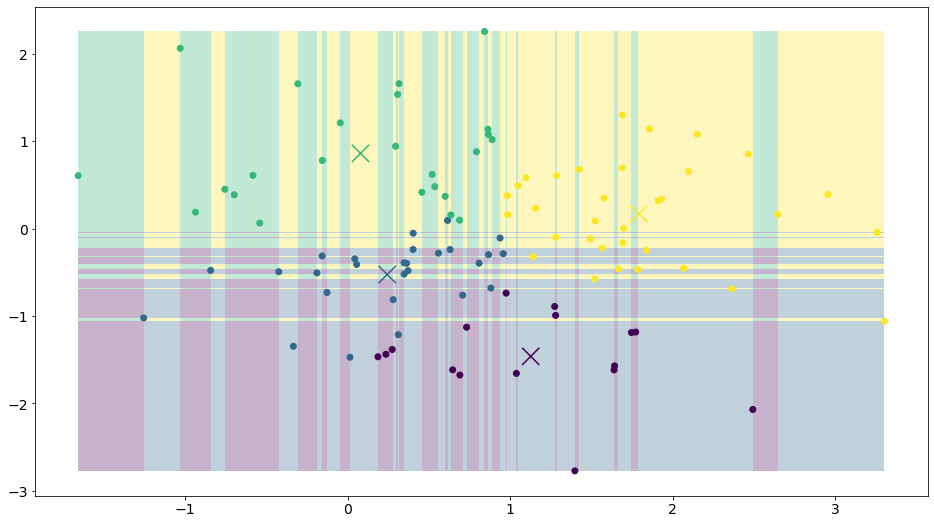

In [6]:
def unflatten_Q(Q_flat):
    Q = np.stack(np.unravel_index(Q_flat, (N, d))).T
    return xr.DataArray(Q, dims=['N', 'd'])


def distributed_lloyd_max(X, R, iters=10, RX=None):
    N, d = X.shape
    M = 2**(R*d)

    # init quantizer
    if RX is None:
        RX = sample_from_X(X, M).rename(N='M')
    Q_flat = np.power(X - RX, 2).sum('d').argmin('M')
    Q = unflatten_Q(Q_flat)

    for i in range(iters):
        RX = optimize_decoder(X, Q, RX, R)
        BX, BQ = optimize_encoder(X, Q, RX, R)
        Q = encode(X, BX, BQ)
    loss = calc_loss(X, Q @ flattener[R][d], RX).mean()
    return RX, BX, BQ, loss

R = 1
X = generate_2d_dataset(100, 0)
RX, BX, BQ, _ = distributed_lloyd_max(X, R=R, iters=30)
Q = encode(X, BX, BQ)
plot(X, BX, BQ, R)

# Non-distributed Lloyd-max

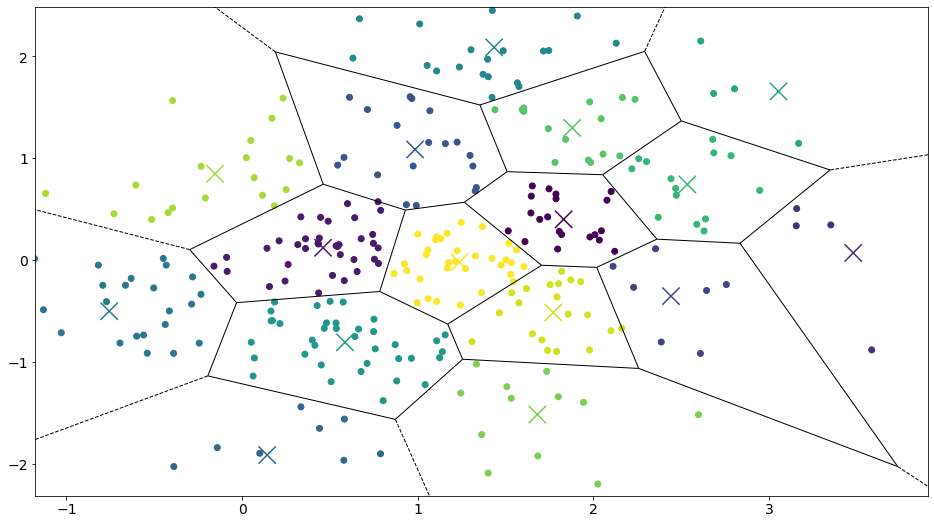

In [7]:
def plot_voronoi(X, RX, Q_flat):
    vor = Voronoi(RX)
    plt.scatter(*X.T, c=Q_flat)
    plt.scatter(*RX.T, marker='x', c=RX['M'], s=300)
    return voronoi_plot_2d(vor,
                           point_size=10,
                           show_points=False,
                           show_vertices=False,
                           ax=plt.gca())


def encode_flat(X, RX):
    return (np.power(X - RX, 2)
              .sum('d')
              .argmin('M')
              .assign_attrs(flat=True))


def lloyd_max(X, R, iters):
    N, d = X.shape
    M = 2**(R*d)

    # init quantizer
    RX = sample_from_X(X, M).rename(N='M')

    Q_flat = encode_flat(X, RX)
    for i in range(iters):
        RX = optimize_decoder(X, Q_flat, RX, R)
        Q_flat = encode_flat(X, RX)
    loss = calc_loss(X, Q_flat, RX)
    return RX, Q_flat, loss.mean()


R = 2
X = generate_2d_dataset(300, 0.3)
RX, Q_flat, loss = lloyd_max(X, R=R, iters=10)

plot_voronoi(X, RX, Q_flat)
plt.show()

## Comparisons

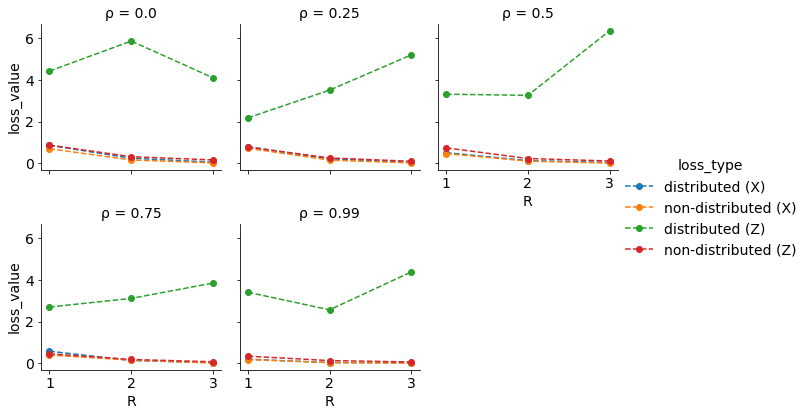

In [8]:
losses = list()
for ρ in [0, 0.25, 0.5, 0.75, 0.99]:
    X = generate_2d_dataset(100, ρ)
    Z = generate_2d_dataset(100, ρ)
    for R in [1, 2, 3]:
        RX_nondist, _, loss_nondist = lloyd_max(X, R=R, iters=30)
        QZ_flat_nondist = encode_flat(Z, RX_nondist)
        loss_nondist_Z = calc_loss(Z, QZ_flat_nondist, RX_nondist).mean()

        RX_dist, BX, BQ, loss_dist = distributed_lloyd_max(X, R, 30)
        QZ_flat_dist = encode(Z, BX, BQ)
        loss_dist_Z = calc_loss(Z, QZ_flat_dist, RX_dist).mean()


        losses.append({'loss_value': loss_dist.item(),
                       'loss_type': 'distributed (X)',
                       'R': R,
                       'ρ': ρ})

        losses.append({'loss_value': loss_nondist.item(),
                       'loss_type': 'non-distributed (X)',
                       'R': R,
                       'ρ': ρ})

        losses.append({'loss_value': loss_dist_Z.item(),
                       'loss_type': 'distributed (Z)',
                       'R': R,
                       'ρ': ρ})

        losses.append({'loss_value': loss_nondist_Z.item(),
                       'loss_type': 'non-distributed (Z)',
                       'R': R,
                       'ρ': ρ})

import seaborn as sns
losses = pd.DataFrame(losses)
g = sns.FacetGrid(losses, col='ρ', hue='loss_type', col_wrap=3)
g = (g.map(plt.plot, 'R', 'loss_value', marker='o', linestyle='dashed')
      .add_legend())
plt.show()